In [1]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
# Register matplotlib converters to be able to plot timestamps
pd.plotting.register_matplotlib_converters()

In [3]:
# Read the dataset
file_path = './dataset/petrol_price.csv'  # Ensure this is the correct file path
try:
    petrol_price_data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"The file {file_path} was not found.")
    # Handle file not found situation, for example by exiting the script
    # exit()

petrol_price_data

,ds,y
0,12-10-2007,9.590761
1,12-11-2007,8.519590
2,12-12-2007,8.183677
3,12/13/2007,8.072467
4,12/14/2007,7.893572
...,...,...
2900,1/16/2016,7.817223
2901,1/17/2016,9.273878
2902,1/18/2016,10.333775
2903,1/19/2016,9.125871


In [4]:
# Convert 'ds' to datetime format mixed
petrol_price_data['ds'] = pd.to_datetime(petrol_price_data['ds'], format='mixed')

# Format the dates in 'YYYY-MM-DD' format
petrol_price_data['ds'] = petrol_price_data['ds'].dt.strftime('%Y-%m-%d')

# Check for NaT in 'ds' and handle it appropriately
if petrol_price_data['ds'].isnull().any():
    print("Some dates couldn't be parsed and are set as NaT.")

petrol_price_data


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [5]:
# Define the model fitting and prediction function
def fit_predict_model(dataframe, interval_width=0.99, changepoint_range=0.8):
    # Initialize the Prophet model with specified parameters
    model = Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False,
                    seasonality_mode='multiplicative', 
                    interval_width=interval_width,
                    changepoint_range=changepoint_range)
    # Fit the model to the data
    model.fit(dataframe)
    
    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=365)
    
    # Predict future values
    forecast = model.predict(future)
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.show()  # Display the plot
    
    return forecast

# Function to detect anomalies in the forecast
def detect_anomalies(forecast_df):
    forecast_df['anomaly'] = 0
    forecast_df['importance'] = 0.0  # Initialize as float for precision
    forecast_df.loc[forecast_df['fact'] > forecast_df['yhat_upper'], 'anomaly'] = 1
    forecast_df.loc[forecast_df['fact'] < forecast_df['yhat_lower'], 'anomaly'] = -1
    forecast_df.loc[forecast_df['anomaly'] == 1, 'importance'] = \
        (forecast_df['fact'] - forecast_df['yhat_upper']) / forecast_df['fact']
    forecast_df.loc[forecast_df['anomaly'] == -1, 'importance'] = \
        (forecast_df['yhat_lower'] - forecast_df['fact']) / forecast_df['fact']
    return forecast_df

22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
/Users/ariffin/Documents/Python/AI/anomaly-detection/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/ariffin/Documents/Python/AI/anomaly-detection/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


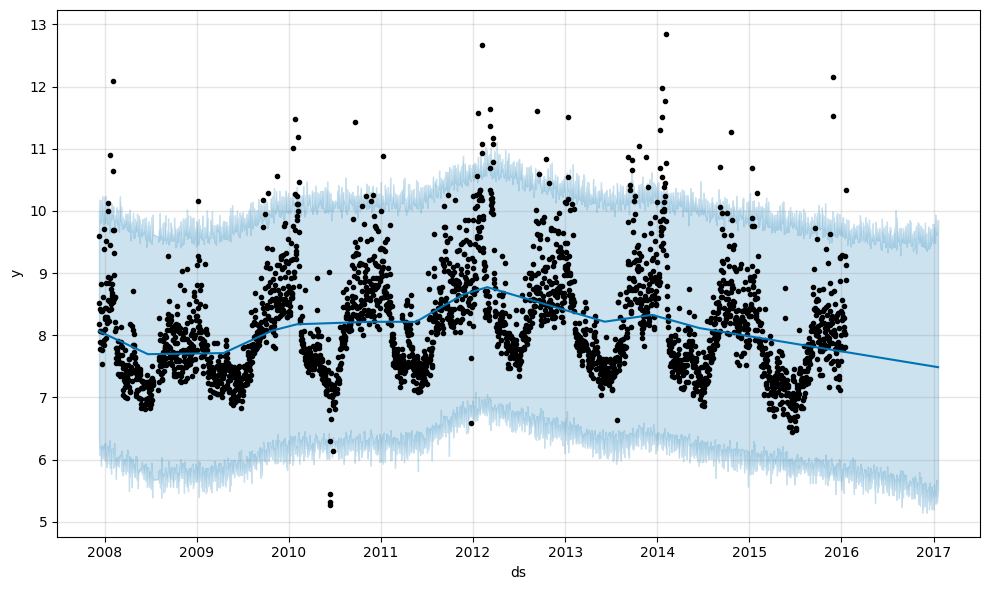

In [6]:
# Fit the model and make a forecast
forecast = fit_predict_model(petrol_price_data[['ds', 'y']])

# Detect anomalies in the forecast
forecast['fact'] = petrol_price_data['y'].reset_index(drop=True)
prediction = detect_anomalies(forecast)

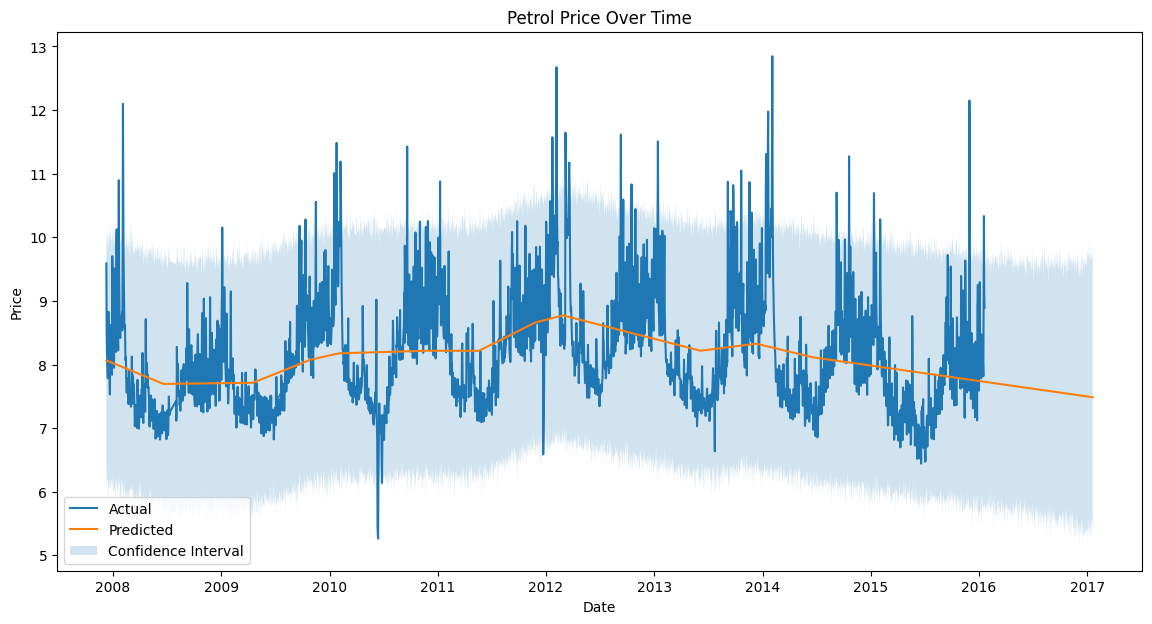

In [7]:
# Plot the results with actual values, predicted values, and confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(prediction['ds'], prediction['fact'], label='Actual')
plt.plot(prediction['ds'], prediction['yhat'], label='Predicted')
plt.fill_between(prediction['ds'], prediction['yhat_lower'], prediction['yhat_upper'], alpha=0.2, label='Confidence Interval')
plt.title('Petrol Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Filter and display data where an anomaly was detected
anomaly_data = prediction[prediction['anomaly'] != 0]
anomaly_data[['anomaly', 'ds', 'fact', 'yhat', 'yhat_upper', 'yhat_lower', 'importance']].head()

,anomaly,ds,fact,yhat,yhat_upper,yhat_lower,importance
34,1,2008-01-13,9.996522,7.999634,9.839823,6.064146,0.015675
35,1,2008-01-14,10.127071,7.997718,9.784937,6.224824,0.033784
42,1,2008-01-21,10.897202,7.984309,9.946741,6.309572,0.087221
55,1,2008-02-04,12.097457,7.957491,10.081512,6.132238,0.166642
56,1,2008-02-05,10.635278,7.955575,10.054779,5.867740,0.054582
